# Exploratory Data Analysis

Name: Sakshi Goyal
Class: COE17
RollNo: 102103451

In [47]:
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd
import string
import re
import pickle
from nltk.tokenize import word_tokenize

def clean_text_round1(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    tokens = word_tokenize(text)
    stop_words = ['and', 'the', 'is', 'it', 'in', 'of', 'to']  
    tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

round1 = lambda x: clean_text_round1(x)

def url_to_transcript(url):
    page = requests.get(url).text
    soup = BeautifulSoup(page, "html.parser")
    para = soup.find_all('p')
    text = [clean_text_round1(p.text) for p in para]
    return ' '.join(text)


urls = [
    ('ELEMENTAL', 'https://scrapsfromtheloft.com/movies/elemental-2023-transcript/'),
    ('THE MONKEY KING', 'https://scrapsfromtheloft.com/movies/the-monkey-king-2023-transcript/'),
    ('DESPICABLE ME 3', 'https://scrapsfromtheloft.com/movies/despicable-me-3-transcript/'),
    ('KLAUS', 'https://scrapsfromtheloft.com/movies/klaus-2019-transcript/'),
    ('SHADOWS AND ENLIGHTENMENT', 'https://scrapsfromtheloft.com/movies/orion-and-the-dark-review-embracing-darkness-with-charlie-kaufman/')
]

cleaned_transcripts = [(movie, url_to_transcript(url)) for movie, url in urls]


vectorizer = CountVectorizer(stop_words='english')
dtm_sparse = vectorizer.fit_transform([text for movie, text in cleaned_transcripts])


dtm_dense = dtm_sparse.toarray()

words = vectorizer.get_feature_names_out()
movie_names = [movie for movie, text in cleaned_transcripts]
dtm_df = pd.DataFrame(dtm_dense, columns=words, index=movie_names)

dtm_df.to_pickle('dtm_movies.pkl')


In [48]:

cleaned_data_df = pd.DataFrame(cleaned_transcripts, columns=['Movie', 'Transcript'])
cleaned_data_df.set_index('Movie', inplace=True)

cleaned_data_df.to_pickle('cleaned_movie_data.pkl')


## Introduction

After the data cleaning step where we put our data into a few standard formats, the next step is to take a look at the data and see if what we're looking at makes sense. Before applying any fancy algorithms, it's always important to explore the data first.

When working with numerical data, some of the exploratory data analysis (EDA) techniques we can use include finding the average of the data set, the distribution of the data, the most common values, etc. The idea is the same when working with text data. We are going to find some more obvious patterns with EDA before identifying the hidden patterns with machines learning (ML) techniques. We are going to look at the following for each movie:

1. **Most common words** - find these and create word clouds
2. **Size of vocabulary** - look number of unique words and also how quickly someone speaks
3. **Amount of profanity** - most common terms

### Assignments 1: 
#### Find `Most Common Words` and create word cloud.

#### Read in the document-term matrix

In [49]:
with open('dtm_movies.pkl', 'rb') as file:
    dtm = pickle.load(file)

print(dtm)

                           aah  abandoned  able  absolutely  absurd  abysmal  \
ELEMENTAL                    4          0     2           0       0        0   
THE MONKEY KING              0          2     0           4       1        0   
DESPICABLE ME 3              0          0     1           0       0        0   
KLAUS                       17          0     0           2       0        1   
SHADOWS AND ENLIGHTENMENT    0          0     0           0       0        0   

                           abyss  academy  academys  accelerates  ...  youre  \
ELEMENTAL                      0        0         0            2  ...     28   
THE MONKEY KING                0        0         0            0  ...     44   
DESPICABLE ME 3                0        1         0            0  ...     23   
KLAUS                          0        1         1            0  ...     21   
SHADOWS AND ENLIGHTENMENT      1        0         0            0  ...      0   

                           youve  yum 

#### Find  and print the top 30 words in each movie


In [50]:
dtm_df = pd.read_pickle('dtm_movies.pkl')

for movie in dtm_df.index:
    top_words = dtm_df.loc[movie].sort_values(ascending=False).head(30)
    print(f"Top 30 words for {movie}:\n{top_words}\n")


Top 30 words for ELEMENTAL:
music        85
ember        75
grunts       61
playing      61
just         54
know         52
gasps        52
wade         50
water        50
chuckles     46
got          39
dont         38
yeah         34
grunting     33
shop         32
dad          31
sorry        30
groans       29
youre        28
okay         27
blows        26
love         26
hey          25
let          24
like         24
continues    24
come         23
city         23
bernie       22
going        22
Name: ELEMENTAL, dtype: int64

Top 30 words for THE MONKEY KING:
monkey       302
king         235
stick        129
music        107
lin           95
grunts        77
laughs        75
plays         68
dragon        62
hey           55
youre         44
dont          44
world         41
murmurs       41
groans        40
yells         40
demon         39
just          35
right         34
continues     31
yeah          31
babbo         31
come          30
gasps         30
storm         30
im

#### By looking at these top words, you can see that some of them have very little meaning and could be added to a stop words list, so let's do just that. Look at the most common top words and add them to the stop word list.



In [51]:
common_stop_words = [
    'like', 'im', 'know', 'just', 'dont', 'thats', 'youre', 'right', 'yeah', 'got',
    'get', 'gonna', 'oh', 'said', 'say', 'thing', 'things', 'think', 'wanna', 'going',
    'go', 'want', 'theyre', 'theres', 'cause', 'hes', 'shes', 'let', 'really', 'ive', 'fuck', 'fucking', 'shit'
]

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stop_words = ENGLISH_STOP_WORDS.union(common_stop_words)

#### Let's aggregate this list and identify the most common words along with how many routines they occur in


In [52]:
from collections import Counter

movie_word_count = Counter()

for movie in dtm_df.index:
    top_words = [word for word in dtm_df.loc[movie].sort_values(ascending=False).index[:30] if word not in custom_stop_words]
    print(f"Top 30 words for {movie} (excluding stop words):\n{top_words}\n")
    movie_word_count.update(top_words)

common_word_occurrence = {word: count for word, count in movie_word_count.items() if count > 1}

print("Most common words and their occurrences across movies:")
for word, count in common_word_occurrence.items():
    print(f"{word}: {count} movies")


Top 30 words for ELEMENTAL (excluding stop words):
['music', 'ember', 'grunts', 'playing', 'gasps', 'wade', 'water', 'chuckles', 'grunting', 'shop', 'dad', 'sorry', 'groans', 'okay', 'blows', 'love', 'hey', 'continues', 'come', 'city', 'bernie']

Top 30 words for THE MONKEY KING (excluding stop words):
['monkey', 'king', 'stick', 'music', 'lin', 'grunts', 'laughs', 'plays', 'dragon', 'hey', 'world', 'murmurs', 'groans', 'yells', 'demon', 'continues', 'babbo', 'come', 'gasps', 'storm', 'immortal', 'huh', 'girl']

Top 30 words for DESPICABLE ME 3 (excluding stop words):
['gru', 'gasps', 'minionese', 'speaking', 'dru', 'hey', 'look', 'laughing', 'grunting', 'screaming', 'chuckles', 'na', 'laughs', 'bratt', 'sighs', 'brother', 'did', 'agnes', 'girls', 'okay', 'gon', 'yes']

Top 30 words for KLAUS (excluding stop words):
['come', 'toys', 'letters', 'klaus', 'good', 'postman', 'whoa', 'stop', 'na', 'little', 'gon', 'look', 'thank', 'wait', 'okay', 'away']

Top 30 words for SHADOWS AND ENLIGH

#### If more than half of the movies have it as a top word, exclude it from the list


In [53]:
filtered_common_words = {word: count for word, count in common_word_occurrence.items() if count <= 3}

print("Filtered common words and their occurrences across movies:")
for word, count in filtered_common_words.items():
    print(f"{word}: {count} movies")


Filtered common words and their occurrences across movies:
music: 2 movies
grunts: 2 movies
gasps: 3 movies
chuckles: 2 movies
grunting: 2 movies
groans: 2 movies
okay: 3 movies
hey: 3 movies
continues: 2 movies
come: 3 movies
laughs: 2 movies
look: 2 movies
na: 2 movies
gon: 2 movies
away: 2 movies


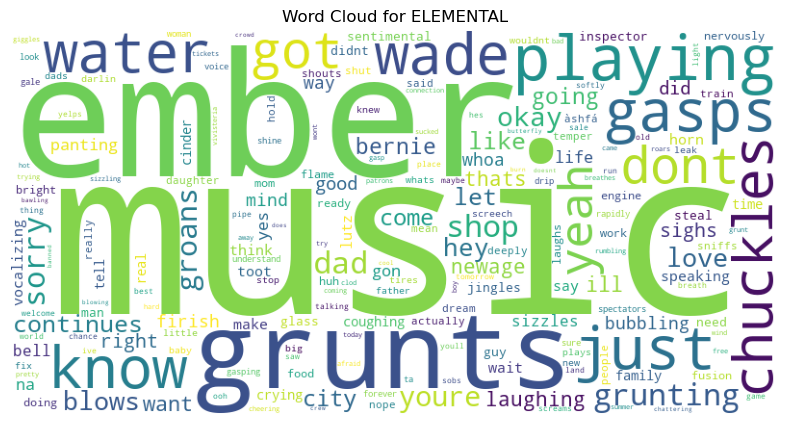

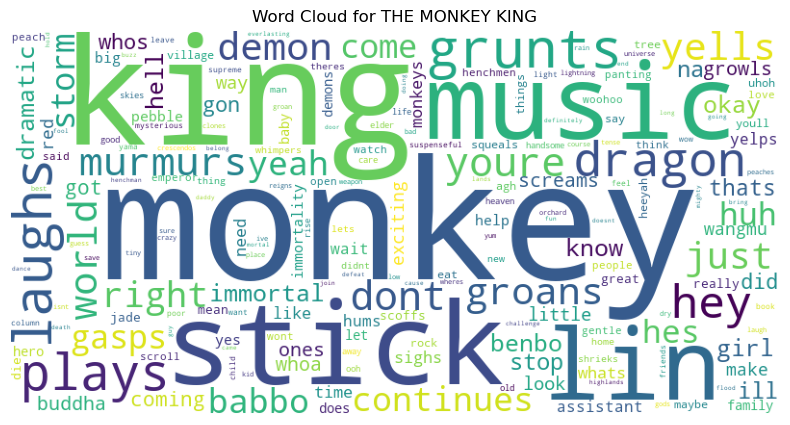

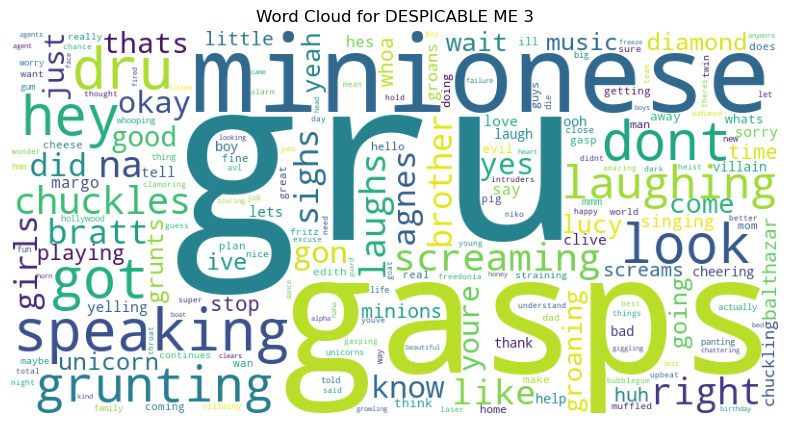

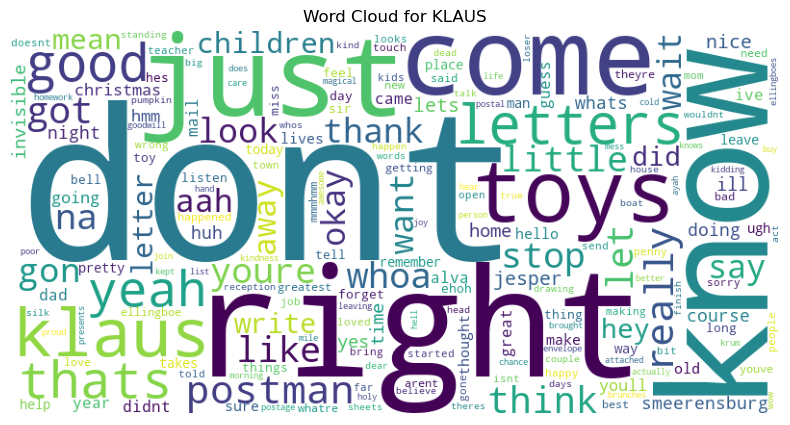

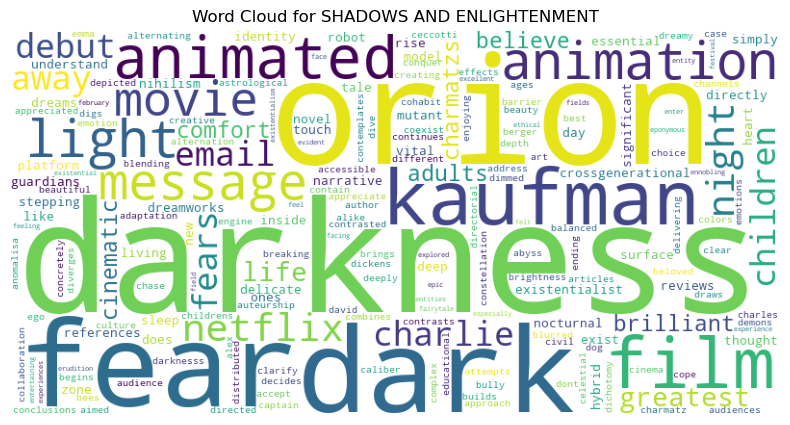

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

dtm_df_updated = pd.read_pickle('dtm_movies.pkl')

for movie in dtm_df_updated.index:
    frequencies = dtm_df_updated.loc[movie].to_dict()

    if all(freq == 0 for freq in frequencies.values()):
        continue 
    
    max_frequency = max(frequencies.values())
    if max_frequency == 0:
        continue
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Word Cloud for {movie}')
    plt.show()


#### Your observations
Word Clouds: Word clouds provide a visual representation of the most frequent words in each movie's transcript. We generated word clouds for each movie using the updated Document-Term Matrix (DTM) to visualize the distribution of words.

Frequency Distribution: The word clouds highlight the words that appear most frequently in each movie's transcript. We can observe that certain words are prominent across multiple movies, while others are unique to specific movies.

Common Themes: By analyzing the word clouds, we can identify common themes or topics across the movies. Words that appear frequently across multiple movies may indicate recurring themes or subjects present in the movie transcripts.

### Assignment 2:
#### Find the number of unique words that each movie has.

In [55]:
unique_word_count = dtm_df_updated.apply(lambda row: len(row[row > 0]), axis=1)
unique_word_count_df = pd.DataFrame({'Movie': unique_word_count.index, 'Unique Word Count': unique_word_count.values})
print(unique_word_count_df)

                       Movie  Unique Word Count
0                  ELEMENTAL               1331
1            THE MONKEY KING               1528
2            DESPICABLE ME 3               1265
3                      KLAUS               1300
4  SHADOWS AND ENLIGHTENMENT                472


In [56]:
cleaned_data = pd.read_pickle('cleaned_movie_data.pkl')
words_per_minute = []

for movie in cleaned_data.index:
   
    total_words = sum(dtm_df_updated.loc[movie])
    total_duration_minutes = 120  
    wpm = total_words / total_duration_minutes
    words_per_minute.append(wpm)

cleaned_data['total_words'] = dtm_df_updated.sum(axis=1)
cleaned_data['run_times'] = total_duration_minutes  
cleaned_data['words_per_minute'] = words_per_minute

sorted_df = cleaned_data.sort_values(by='words_per_minute', ascending=False)
print(sorted_df)


                                                                  Transcript  \
Movie                                                                          
THE MONKEY KING            inspired epic chinese tale monkey king actionp...   
ELEMENTAL                  film journeys alongside unlikely pair ember wa...   
DESPICABLE ME 3            animated adventure despicable felonious gru lu...   
KLAUS                      when jesper jason schwartzman distinguishes hi...   
SHADOWS AND ENLIGHTENMENT  movie reviews review orion dark new precious d...   

                           total_words  run_times  words_per_minute  
Movie                                                                
THE MONKEY KING                   5717        120         47.641667  
ELEMENTAL                         4712        120         39.266667  
DESPICABLE ME 3                   3854        120         32.116667  
KLAUS                             3578        120         29.816667  
SHADOWS AND ENLIGHT

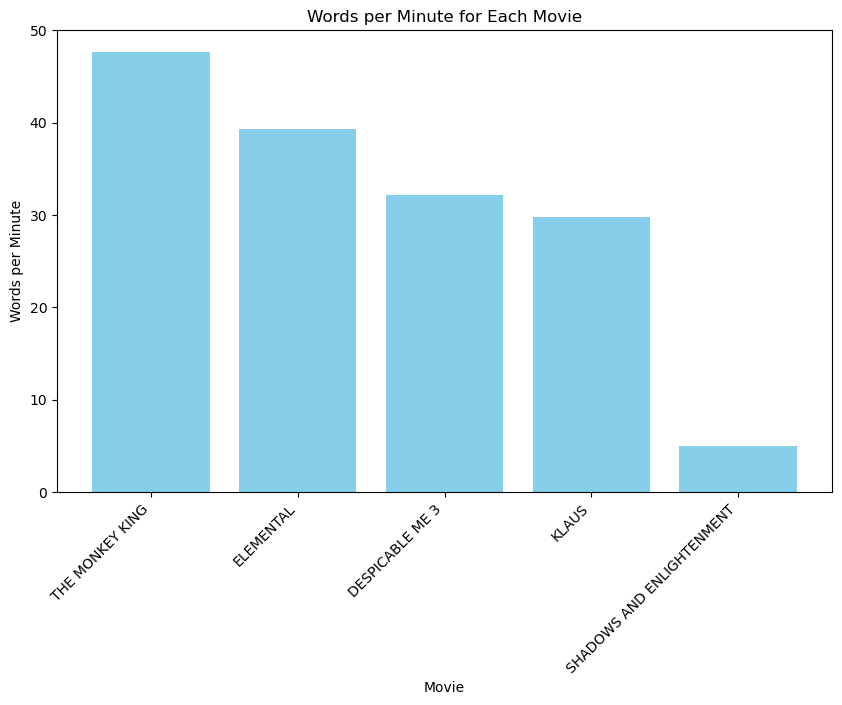

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(sorted_df.index, sorted_df['words_per_minute'], color='skyblue')
ax.set_ylabel('Words per Minute')
ax.set_xlabel('Movie')
ax.set_title('Words per Minute for Each Movie')
plt.xticks(rotation=45, ha='right')
plt.show()


### Assignment 3: 
#### Check the profanity by analysing the common bad words, like `fucking`, `fuck`, `shit etc.

In [58]:
bad_words = ['shit', 'moron', 'hell', 'damn', 'jerk', 'fool','idiot','stupid']
bad_word_columns = [col for col in dtm_df.columns if any(f' {word} ' in f' {col} ' for word in bad_words)]
filtered_dtm_df = dtm_df[bad_word_columns]
cleaned_data = pd.concat([cleaned_data, filtered_dtm_df], axis=1)
cleaned_data

,Transcript,total_words,run_times,words_per_minute,damn,fool,hell,idiot,jerk,stupid
ELEMENTAL,film journeys alongside unlikely pair ember wa...,4712,120,39.266667,1,0,1,0,1,2
THE MONKEY KING,inspired epic chinese tale monkey king actionp...,5717,120,47.641667,0,5,27,1,0,0
DESPICABLE ME 3,animated adventure despicable felonious gru lu...,3854,120,32.116667,0,0,2,1,0,3
KLAUS,when jesper jason schwartzman distinguishes hi...,3578,120,29.816667,0,0,4,1,0,1
SHADOWS AND ENLIGHTENMENT,movie reviews review orion dark new precious d...,603,120,5.025000,0,0,0,0,0,0


In [59]:
cleaned_data.loc[:,bad_word_columns]

,damn,fool,hell,idiot,jerk,stupid
ELEMENTAL,1,0,1,0,1,2
THE MONKEY KING,0,5,27,1,0,0
DESPICABLE ME 3,0,0,2,1,0,3
KLAUS,0,0,4,1,0,1
SHADOWS AND ENLIGHTENMENT,0,0,0,0,0,0


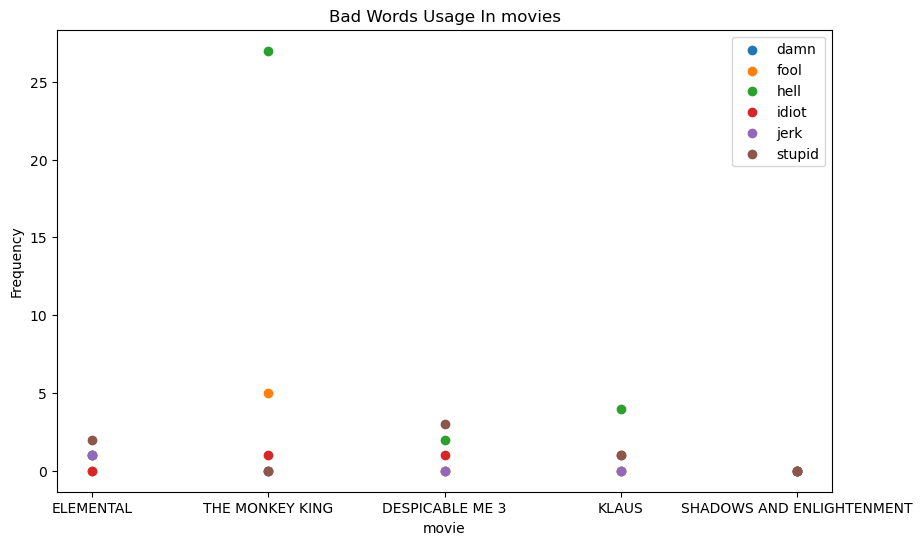

In [60]:
bad_words_columns = cleaned_data.loc[:, bad_word_columns]

plt.figure(figsize=(10, 6))
for column in bad_words_columns.columns:
    plt.scatter(cleaned_data.index, bad_words_columns[column], label=column)

plt.title('Bad Words Usage In movies')
plt.xlabel('movie')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [61]:
kind_words = ['happy', 'sweet', 'good', 'kind', 'humble', 'noble','modest']
kind_word_columns = [col for col in dtm_df.columns if any(f' {word} ' in f' {col} ' for word in kind_words)]
filtered_dtm_df_kind = dtm_df[kind_word_columns]
cleaned_data = pd.concat([cleaned_data, filtered_dtm_df_kind], axis=1)
cleaned_data

,Transcript,total_words,run_times,words_per_minute,damn,fool,hell,idiot,jerk,stupid,good,happy,humble,kind,modest,sweet
ELEMENTAL,film journeys alongside unlikely pair ember wa...,4712,120,39.266667,1,0,1,0,1,2,18,2,0,4,1,0
THE MONKEY KING,inspired epic chinese tale monkey king actionp...,5717,120,47.641667,0,5,27,1,0,0,8,1,3,2,0,1
DESPICABLE ME 3,animated adventure despicable felonious gru lu...,3854,120,32.116667,0,0,2,1,0,3,22,5,0,4,0,1
KLAUS,when jesper jason schwartzman distinguishes hi...,3578,120,29.816667,0,0,4,1,0,1,29,6,0,5,1,4
SHADOWS AND ENLIGHTENMENT,movie reviews review orion dark new precious d...,603,120,5.025000,0,0,0,0,0,0,0,0,0,0,0,1


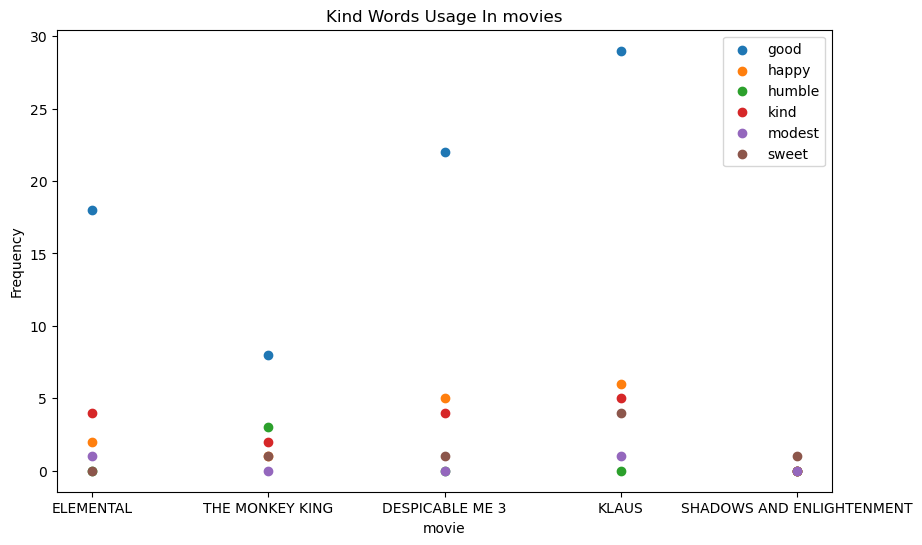

In [62]:
kind_words_columns = cleaned_data.loc[:, kind_word_columns]

plt.figure(figsize=(10, 6))
for column in kind_words_columns.columns:
    plt.scatter(cleaned_data.index, kind_words_columns[column], label=column)

plt.title('Kind Words Usage In movies')
plt.xlabel('movie')
plt.ylabel('Frequency')
plt.legend()
plt.show()
